# Regional differences in chlamydia prevalence, proportion diagnosed and positivity

In this example, we assume that the incidence of chlamydia is homogeneous across England and investigate whether the differences in testing rates could explain differences in diagnoses and positivity.


In [1]:
# this script contains the functions for observed testing and diagnosis rates
# running this script takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# this script provides a function for calculating the likelihood of categorical data
%run -i multinomial_pmf.py

# this script samples model parameters from prior distributions, following the method in england.ipynb.
%run -i sample_parameters.py

0.227636363636
14.2892034953
0.3584
0.2703


Surveillance data on chlamydia testing and diagnosis rates by English local authority 2012 were downloaded from: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 17 April 2015).

In [2]:
# now read in the regional (upper-tier local authority) testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

alldata = pd.read_csv('2012_age_sex_region.csv')
alldata = alldata[alldata.laut != 'Isles of Scilly'] # remove Scilly Isles because of small numbers
alldata.index = range(len(alldata))
alldata

# laut: Local Authority Upper Tier
# gor: Government Office Region
# phec: Public Health England Region
# pher: Public Health England Centre

,laut_code,laut,gor,phec,pher,tests.male.15-19,tests.male.20-24,tests.male.total,tests.female.15-19,tests.female.20-24,...,positives.female.20-24,positives.female.total,positives.total.15-19,positives.total.20-24,positives.total,population.male.15-19,population.male.20-24,population.female.15-19,population.female.20-24,population.total
0,E09000002,Barking and Dagenham,london,London,London,1741,1466,3207,2354,2811,...,174,407,317,284,601,6672,6484,6137,6532,25825
1,E09000003,Barnet,london,London,London,491,1514,2005,1568,3591,...,232,380,194,370,564,10694,11651,9883,11938,44166
2,E09000004,Bexley,london,London,London,631,990,1621,1355,1795,...,121,255,189,201,390,7850,7582,7705,7709,30846
3,E09000005,Brent,london,London,London,1209,2818,4027,2478,5259,...,331,565,333,560,893,9809,11764,8587,11081,41241
4,E09000006,Bromley,london,London,London,1049,1278,2327,1935,2573,...,139,277,199,249,448,9289,7845,8810,8460,34404
5,E09000007,Camden,london,London,London,1225,2310,3535,3182,6368,...,341,585,358,525,883,5915,10708,5777,12163,34563
6,E09000001,City of London,london,London,London,12,25,37,12,88,...,5,7,2,7,9,113,232,118,263,726
7,E09000008,Croydon,london,London,London,1570,2360,3930,3442,4996,...,392,809,563,679,1242,12161,11330,11377,11696,46564
8,E09000009,Ealing,london,London,London,1126,1811,2937,1842,3359,...,204,333,177,346,523,9660,11740,8980,11077,41457
9,E09000010,Enfield,london,London,London,609,1353,1962,1852,3732,...,193,329,180,273,453,10808,10346,9714,10974,41842


We now infer percentage diagnosed and positivity in men and women by LAUT, given local numbers of tests and diagnoses.

In [3]:
# set up arrays to store, for each LAUT: 
test_sample_m = empty([n_sample, len(alldata)]) # testing rate
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_m = empty([n_sample, len(alldata)]) # observed diagnosis rate
diag_sample_f = empty([n_sample, len(alldata)])
diag_m_laut = empty([n_sample, len(alldata)]) # predicted diagnosis rate
diag_f_laut = empty([n_sample, len(alldata)])
scr_m = empty([n_sample, len(alldata)]) # screening (assuming homogeneous incidence)
scr_f = empty([n_sample, len(alldata)])
scr_m_laut = empty([n_sample, len(alldata)]) # screening (estimated for each LAUT separately)
scr_f_laut = empty([n_sample, len(alldata)])
inc_m_laut = empty([n_sample, len(alldata)])  # estimated incidence
inc_f_laut = empty([n_sample, len(alldata)])
prev_m_laut = empty([n_sample, len(alldata)]) # estimated prevalence
prev_f_laut = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.laut[i]
    
    #####
    # men
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_m[:,i] = random.gamma(alldata['tests.male.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    diag_sample_m[:,i] = random.gamma(alldata['positives.male.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
        
    # screening and diagnosis rates
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_m_laut[j,i], scr_m_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                                sc_m[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_m[j], 
                                p_false_pos_m[j]
                            ])])) - array([test_sample_m[j,i],diag_sample_m[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_m_laut[j,i] = dyn_fun(inc_m_laut[j,i]*p_asymp_m[j], sc_m[j] + scr_m_laut[j,i]*p_true_pos_m[j], inc_m_laut[j,i]*(1-p_asymp_m[j]), sc_m[j] + scr_m_laut[j,i]*p_true_pos_m[j] + att_symp[j]*p_true_pos_m[j])
    
    #####
    # women
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = random.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = random.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)

    # screening and diagnosis rates
    diag_f_laut[:,i] = zeros(n_sample)
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_f_laut[j,i], scr_f_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                                sc_f[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_f[j], 
                                p_false_pos_f[j]
                            ])])) - array([test_sample_f[j,i],diag_sample_f[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_f_laut[j,i] = dyn_fun(inc_f_laut[j,i]*p_asymp_f[j], sc_f[j] + scr_f_laut[j,i]*p_true_pos_f[j], inc_f_laut[j,i]*(1-p_asymp_f[j]), sc_f[j] + scr_f_laut[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j])


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


## Testing and diagnosis rates

(0, 0.1)

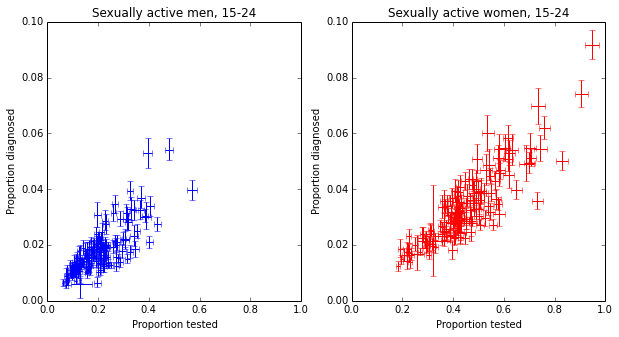

In [4]:
# plot testing and diagnosis rates to show correlation
import matplotlib.pyplot as plt
%matplotlib inline

def plt_ppc(ax, xsample, ysample, index, ci, col, alpha=1): # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50, index), 
                percentile(ysample, 50, index), 
                xerr=squeeze(
                    array([[percentile(xsample,50, index) - percentile(xsample, (100.-ci)/2, index)], 
                           [percentile(xsample, (100.+ci)/2, index) - percentile(xsample,50, index)]])
            ), 
                yerr=squeeze(
                    array([[percentile(ysample,50, index) - percentile(ysample, (100.-ci)/2, index)], 
                           [percentile(ysample, (100.+ci)/2, index) - percentile(ysample,50, index)]])
            ),
                linestyle = 'None', color = col, alpha=alpha)

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt_ppc(ax1, test_sample_m, diag_sample_m, 0, 95, 'b')
plt_ppc(ax2, test_sample_f, diag_sample_f, 0, 95, 'r')

ax1.set_title('Sexually active men, 15-24'); ax2.set_title('Sexually active women, 15-24')

ax1.set_xlabel('Proportion tested'); ax2.set_xlabel('Proportion tested')
ax1.set_ylabel('Proportion diagnosed'); ax2.set_ylabel('Proportion diagnosed')

ax1.set_xlim([0,1]); ax2.set_xlim([0,1])
ax1.set_ylim([0,0.1]); ax2.set_ylim([0,0.1])

## Positivity and prevalence

Plotting the proportion of the sexually active population tested for chlamydia against the proportion diagnosed shows clearly the correlation between the two: as more tests are conducted, more infections are discovered.

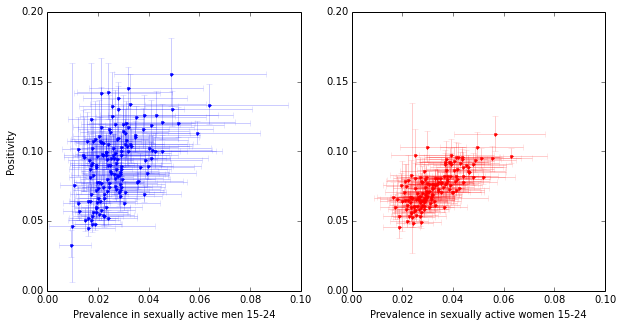

In [5]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# positivity
pos_m_laut = diag_sample_m/test_sample_m
pos_f_laut = diag_sample_f/test_sample_f

# add to plot
plt_ppc(ax1, prev_m_laut, pos_m_laut, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(prev_m_laut, 50, 0), percentile(pos_m_laut, 50, 0), '.b')
plt_ppc(ax2, prev_f_laut, pos_f_laut, 0, 95, 'r', alpha=0.2)
ax2.plot(percentile(prev_f_laut, 50, 0), percentile(pos_f_laut, 50, 0), '.r')

ax1.set_xlim([0,0.1]); ax1.set_ylim([0,0.2])
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.set_ylabel('Positivity')
#ax1.set_title('Sexually active men 15-24')
ax2.set_xlim([0,0.1]); ax2.set_ylim([0,0.2])
ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')


Although there is a positive correlation between prevalence and positivity, positivity is consistently higher than prevalence because the sample of individuals tested is enriched by those seeking treatment because of symptoms. There are also a large number of possible comparisons between local authorities in which the authority with the lower positivity has the higher prevalence.

## Local differences in prevalence

[]

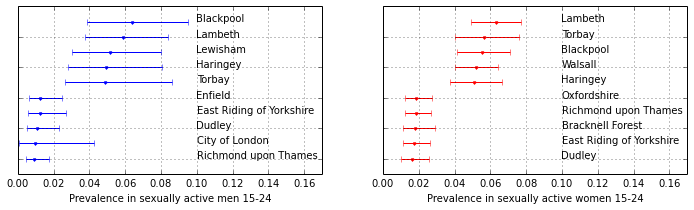

In [6]:
fig = plt.figure(figsize = (12,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

order_m = argsort(percentile(prev_m_laut,50,axis=0)) # order by prevalence in men
order_m = order_m[append(range(0,5),range(146,151))] # Comment-out this line to plot all LAUTS. You will also need to adjust axis sizes.
ax1.errorbar(
    y = range(len(order_m)), 
    x = (percentile(prev_m_laut,50,axis=0))[order_m], 
    xerr=array([percentile(prev_m_laut[:,order_m],50,axis=0) - percentile(prev_m_laut[:,order_m],2.5,axis=0),
            percentile(prev_m_laut[:,order_m],97.5,axis=0) - percentile(prev_m_laut[:,order_m],50,axis=0)]
            ), 
    fmt='.')

ax1.set_ylim(-1, len(order_m)); ax1.set_xlim(0, 0.17)
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.grid(True)
ax1.set_yticklabels([])

order_f = argsort(percentile(prev_f_laut,50,axis=0)) # order by prevalence in women
order_f = order_f[append(range(0,5),range(146,151))] # Comment-out this line to plot all LAUTS. You will also need to adjust axis sizes.
ax2.errorbar(
    y = range(len(order_f)), 
    x = (percentile(prev_f_laut,50,axis=0))[order_f], 
    xerr=array([percentile(prev_f_laut[:,order_f],50,axis=0) - percentile(prev_f_laut[:,order_f],2.5,axis=0),
            percentile(prev_f_laut[:,order_f],97.5,axis=0) - percentile(prev_f_laut[:,order_f],50,axis=0)]
            ), 
    color='r',fmt='.')  

for i in xrange(10):
    ax1.text(0.1, i, alldata.laut[order_m[i]])
    ax2.text(0.1, i, alldata.laut[order_f[i]])

ax2.set_ylim(-1, len(order_f)); ax2.set_xlim(0, 0.17)
ax2.set_xlabel('Prevalence in sexually active women 15-24')
ax2.grid(True)
ax2.set_yticklabels([])


In general, the 95% credible intervals for the highest and lowest regions do not overlap at all, or only slightly. However, there are over 100 LAUTs with intermediate prevalence in which the distributions do overlap. (A plot showing all LAUTs can be obtained by commenting-out the lines indicated above.) Although there are regional differences in prevalence, they are generally small compared with the uncertainty in our estimates. Only in the most extreme cases can differences be clearly resolved.

We also plot inferred prevalence against deprivation (rank of average score from the English Indices of Deprivation 2010):

no Isles of Scilly 00HF E06000053


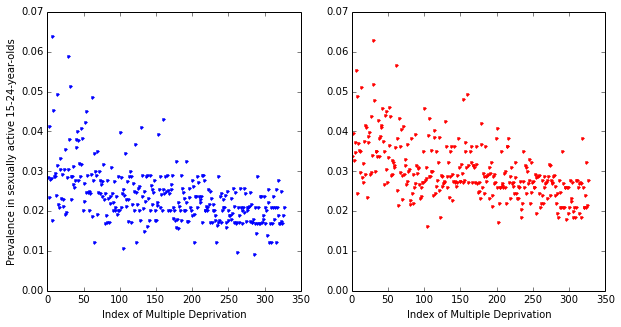

In [7]:
# lookup table for local authority coding in NCSP vs deprivation data
code_key = pd.read_csv('code_equivalents.csv') # downloaded from https://data.gov.uk/dataset/local-authority-districts-uk-2012-names-and-codes 4 January 2016
district_key = pd.read_csv('LAD12_CTY12_EN_LU.csv')
# indices of deprivation
deprivation = pd.read_csv('deprivation_indices_2010.csv') # downloaded from downloaded from https://www.gov.uk/government/statistics/english-indices-of-deprivation-2010 1 December 2010

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

quantiles_m = percentile(prev_m_laut, [50,2.5,97.5], 0)
quantiles_f = percentile(prev_f_laut, [50,2.5,97.5], 0)

for i in deprivation.index:
    
    old_code = deprivation[u'LA CODE'][i]
    new_code = code_key['Current code'][code_key['Former code'] == old_code].tolist()[0]
    
    # fudge for Northumberland, because a new code was allocated when boundaries changed:
    if new_code == 'E06000048': # Northumberland
        new_code = 'E06000057'
    
    if new_code in alldata.laut_code.tolist(): # if LAUT can be found in NCSP data using new code
        ax1.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.laut_code == new_code)],
                '.b')
        ax2.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.laut_code == new_code)],
                '.r')
    elif old_code in district_key['LAD12CDO'].tolist(): # if LAUT can be found in list of districts
        new_code = district_key['CTY12CD'][district_key['LAD12CDO']==old_code].tolist()[0]
        # fudge for Gateshead, because a new code was allocated when boundaries changed:
        if old_code == '00CH':
            new_code = 'E08000037'
        ax1.plot(deprivation[u'Rank of Average Score'][i],
            quantiles_m[0][where(alldata.laut_code == new_code)],
            '.b') 
        ax2.plot(deprivation[u'Rank of Average Score'][i],
            quantiles_f[0][where(alldata.laut_code == new_code)],
            '.r')            
    else: 
        print 'no', deprivation[u'LA NAME'][i], old_code, new_code # Scilly Isles not plotted because excluded due to low numbers
    
ax1.set_xlim([0,350]); ax1.set_ylim([0,0.07])
ax1.set_xlabel('Index of Multiple Deprivation')
ax1.set_ylabel('Prevalence in sexually active 15-24-year-olds')
#ax1.set_title('Sexually active men 15-24 years')
ax2.set_xlim([0,350]); ax2.set_ylim([0,0.07])
ax2.set_xlabel('Index of Multiple Deprivation')
#ax2.set_ylabel('Prevalence')
#ax2.set_title('Sexually active women 15-24 years')


The pattern shown, of higher prevalence in more deprived areas, agrees with the primary analysis of Natsal-3 which identified index of multiple deprivation quintile as a risk factor for chlamydia infection.

The wide credible intervals (CIs) for prevalence make it difficult to resolve differences between LAUTs. However, some of the variability in sampled prevalence which determines the width of the CIs is due to uncertainty in the model parameters (natural history of infection, test performance and treatment seeking behaviour) rather than in the data (testing and diagnosis rates). Because the model parameters should have the same - albeit unknown - values across LAUTs, we can resolve differences in prevalence more clearly by removing the variability due to model parameters and comparing prevalence sampled for each LAUT, given a set of model parameters.

(0, 0.1)

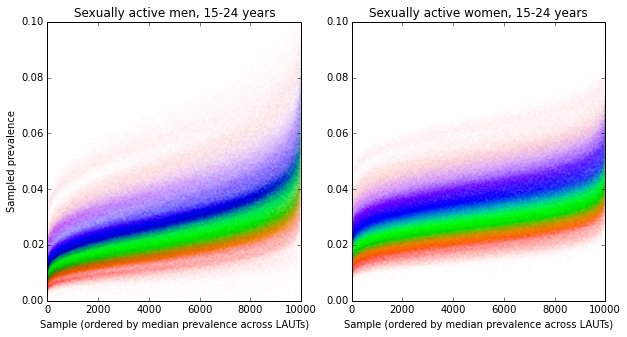

In [8]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# sort samples
prev_m_laut = prev_m_laut[argsort(percentile(prev_m_laut,50,1)),:]
prev_f_laut = prev_f_laut[argsort(percentile(prev_f_laut,50,1)),:]

rb = plt.get_cmap('gist_rainbow')  # this returns a colormap
ax1.set_color_cycle(rb(array(range(151))/151.))
p1=ax1.plot(range(n_sample),prev_m_laut[:,argsort(percentile(prev_m_laut,50,0))], '.', markersize=0.01,alpha=0.5)
ax2.set_color_cycle(rb(array(range(151))/151.))
p2=ax2.plot(range(n_sample),prev_f_laut[:,argsort(percentile(prev_f_laut,50,0))], '.', markersize=0.01,alpha=0.5)

ax1.set_xlabel('Sample (ordered by median prevalence across LAUTs)')
ax1.set_ylabel('Sampled prevalence')
ax1.set_title('Sexually active men, 15-24 years')
ax1.set_ylim([0,0.1])
ax2.set_xlabel('Sample (ordered by median prevalence across LAUTs)')
ax2.set_title('Sexually active women, 15-24 years')
ax2.set_ylim([0,0.1])

In each panel (left, men; right, women) one dot represents one sampled prevalence in one local authority. Its position on the x-axis corresponds to one set of model parameters and indicates whether this set generally estimated prevalence to be low, intermediate or high by ordering for the median prevalence across LAUTs. The position on the y-axis is the sampled prevalence. The colour is unique to each LAUT, and determined on a colour scale according to that LAUT’s median sampled prevalence so that low-prevalence LAUTs are red and high-prevalence are violet. 

The samples for each LAUT form a band – indicating that rank of prevalence is preserved to some extent across samples. The fact that the bands smear into each other shows that there is some swapping of rank order – this is due to uncertainty in the rate of testing and diagnosis. The y-range over which the band moves as it goes from left to right is at least as great as the thickness of the band itself, showing that uncertainty in the model parameters contributes at least as much variation in the final sample as does uncertainty in the testing and diagnosis rates.

Another approach to examing the same question is shown below:

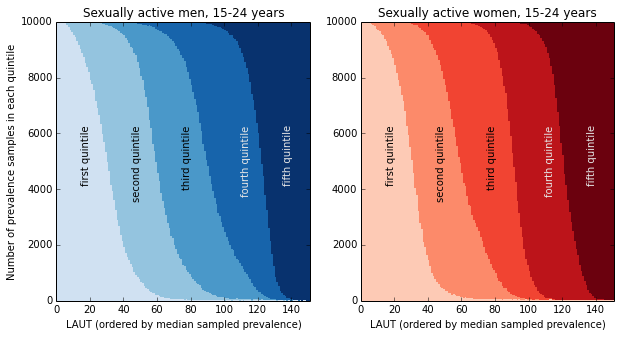

In [9]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# sort lauts
prev_m_laut = prev_m_laut[:,argsort(percentile(prev_m_laut,50,0))]
prev_f_laut = prev_f_laut[:,argsort(percentile(prev_f_laut,50,0))]

# men
blues = plt.get_cmap('Blues')
quintiles = 5*argsort(prev_m_laut,axis=1)/151
sizes = [bincount(quintiles[:,i], minlength=5) for i in range(151)]
ax1.bar(range(151), [sizes[i][0] for i in range(151)], 1, color=blues(0.2), edgecolor='None')
ax1.bar(range(151), [sizes[i][1] for i in range(151)], 1, [sizes[i][0] for i in range(151)], color=blues(0.4), edgecolor='None')
ax1.bar(range(151), [sizes[i][2] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] for i in range(151)], color=blues(0.6), edgecolor='None')
ax1.bar(range(151), [sizes[i][3] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] + sizes[i][2] for i in range(151)], color=blues(0.8), edgecolor='None')
ax1.bar(range(151), [sizes[i][4] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] + sizes[i][2] + sizes[i][3] for i in range(151)], color=blues(0.99), edgecolor='None')

ax1.annotate('first quintile', [15, 6000], rotation = 'vertical')
ax1.annotate('second quintile', [45, 6000], rotation = 'vertical')
ax1.annotate('third quintile', [75, 6000], rotation = 'vertical')
ax1.annotate('fourth quintile', [110, 6000], rotation = 'vertical', color='0.9')
ax1.annotate('fifth quintile', [135, 6000], rotation = 'vertical', color='0.9')

ax1.set_xlim([0,151])
ax1.set_xlabel('LAUT (ordered by median sampled prevalence)')
ax1.set_ylabel('Number of prevalence samples in each quintile')
ax1.set_title('Sexually active men, 15-24 years')

# women
reds = plt.get_cmap('Reds')
quintiles = 5*argsort(prev_f_laut,axis=1)/151
sizes = [bincount(quintiles[:,i], minlength=5) for i in range(151)]
ax2.bar(range(151), [sizes[i][0] for i in range(151)], 1, color=reds(0.2), edgecolor='None')
ax2.bar(range(151), [sizes[i][1] for i in range(151)], 1, [sizes[i][0] for i in range(151)], color=reds(0.4), edgecolor='None')
ax2.bar(range(151), [sizes[i][2] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] for i in range(151)], color=reds(0.6), edgecolor='None')
ax2.bar(range(151), [sizes[i][3] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] + sizes[i][2] for i in range(151)], color=reds(0.8), edgecolor='None')
ax2.bar(range(151), [sizes[i][4] for i in range(151)], 1, [sizes[i][0] + sizes[i][1] + sizes[i][2] + sizes[i][3] for i in range(151)], color=reds(0.99), edgecolor='None')

ax2.annotate('first quintile', [15, 6000], rotation = 'vertical')
ax2.annotate('second quintile', [45, 6000], rotation = 'vertical')
ax2.annotate('third quintile', [75, 6000], rotation = 'vertical')
ax2.annotate('fourth quintile', [110, 6000], rotation = 'vertical', color='0.9')
ax2.annotate('fifth quintile', [135, 6000], rotation = 'vertical', color='0.9')

ax2.set_xlim([0,151])
ax2.set_xlabel('LAUT (ordered by median sampled prevalence)')
ax2.set_title('Sexually active women, 15-24 years')

This time one column in the x-direction represents one LAUT, ordered by median sampled prevalence (lowest to highest). Each column is filled according to how many times out of 10000 samples the LAUT fell into the lowest, second, third, fourth or highest quintile for prevalence. Samples for the lowest-prevalence LAUTs are almost always in the lowest quintile, with increasing numbers in the second, third, fourth and fifth as median sampled prevalence increases. Although some LAUTs might be placed into two or even three different quintiles depending on the model parameters, there is again a clear order of prevalence which is generally preserved regardless of the particular sampled model parameters.

## Prevalence and incidence

Finally, we plot incidence in each sex against prevalence in the other to examine the effect of infection levels in men on the rate of new infections in women, and vice versa. To make the plots easier to interpret, we restrict our attention to 14 regions with the highest and lowest proportion tested and diagnosed and positivity in men and women.

In [10]:
hl = ['Blackpool','Bracknell Forest','Cambridgeshire','County Durham','Dudley', \
    'East Riding of Yorkshire','Hillingdon','Kirklees','Lambeth','Portsmouth', \
    'Sandwell','Torbay','Walsall','West Berkshire']
ofinterest = where(alldata.laut.isin(hl))

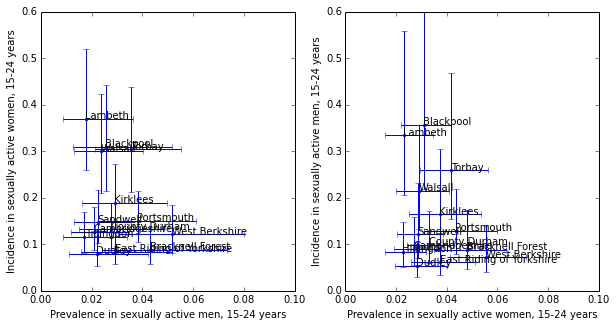

In [11]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = percentile(prev_m_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])

x = percentile(prev_f_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])

ax1.set_xlim(0,0.1); ax2.set_xlim(0,0.1)
ax1.set_xlabel('Prevalence in sexually active men, 15-24 years'); ax2.set_xlabel('Prevalence in sexually active women, 15-24 years')
ax1.set_ylim(0,0.6); ax2.set_ylim(0,0.6)
ax1.set_ylabel('Incidence in sexually active women, 15-24 years'); ax2.set_ylabel('Incidence in sexually active men, 15-24 years')



An natural question is why some LAUTs have higher incidence and prevalence than others. One possibility is that higher screening rates in some areas lower prevalence and incidence. To investigate this, plot incidence against screening in men and women:

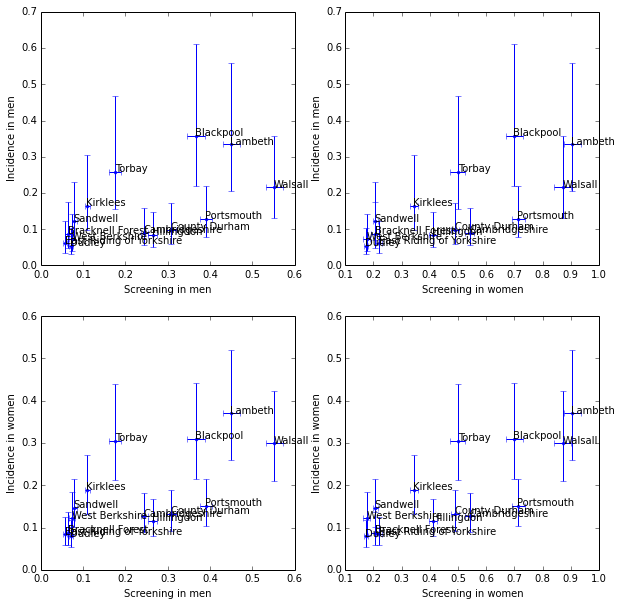

In [12]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = percentile(scr_m_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Incidence in men')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Incidence in men')

x = percentile(scr_m_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax3.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax3.text(x[i], y[i], alldata.laut[i])
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Incidence in women')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax4.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax4.text(x[i], y[i], alldata.laut[i])
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Incidence in women')

In fact, areas with more screening tend to have higher incidence, although the correlations are fairly weak. We also examine the relationship with prevalence:

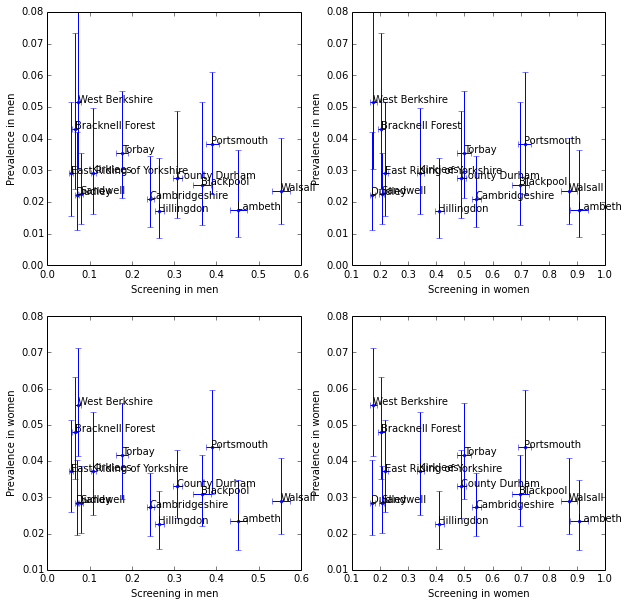

In [13]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = percentile(scr_m_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Prevalence in men')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Prevalence in men')

x = percentile(scr_m_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - y)
ax3.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax3.text(x[i], y[i], alldata.laut[i])
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Prevalence in women')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - y)
ax4.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax4.text(x[i], y[i], alldata.laut[i])
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Prevalence in women')

Prevalence is also generally higher in areas with more screening, but the relationship is complex.